
# Creation of a quantization, use and evaluation pipeline, featuring LLaMA2 7B model

In this notebook, we evaluate the impact quantization has in a common use LLM model, in our case LLaMA 2 7B, evaluating it in a sentiment analysis task. Our pipeline is defined as follows:
- Add a classification layer at the end of the not-quantized model and train this new model with our dataset.
- Quantize the model using **BitsAndBytes**, **GPTQ**, **HQQ**, **Quanto** in 8bit, 4 bit  and 3 bit variants (the later only with GPTQ and HQQ).
- Compare the performance of our modelsin terms of precission, memory use, inference speed and emissions.

We follow this approach because it is the easiest approach to follow. Another option would be to firstly quantize the base model and then add the classification layer and train it. In fact, one could think this approach is better than the previously exposed. However, lots of problems are encountered doing this, because fine tuning an already quantized model is not a good practice. 

### Goals
1. Analize the impact quantization has on performance.
2. Compare the efficiency and precision of the quantized models with the not-quantized model.


## Hardware and software

### Hardware
- CPU: Intel(R) Xeon(R) Silver 4316 CPU @ 2.30GHz
- RAM: 985 GB
- GPU: NVIDIA A100-PCIE-40GB
### Software
For this project, we used the following python libraries: torch, transformers, time and datasets, among others. Of course, all the libraries that these libraries have dependencies with are needed too.
We also used some other libraries or tools that help to evaluate the results. For example, the library CodeCarbon was used to collect emissions data, and the Weights and Biases (Wandb) platform was used to collect and visualize metrics. 


## Project pipeline

### 1. Base model preparation
The base model used is **LLaMA 2 (7B)**. We added a classifier layer to it by loading it with the LlamaForSequenceClassification function from the Transformers library. Then, fine tuning was performed using the **TweetEval** dataset, focusing on the sentiment classification task on its training subset. To make the fine-tuning more efficient and lightweight, Low-Rank Adaptation (LoRA) was applied to the attention layers using the PEFT library, reducing the number of trainable parameters. Training was carried out on a single  NVIDIA A100 40GB GPU using the Hugging Face ***Trainer*** API with a learning rate of $2 \times 10^{-5}$, a batch size of 8, and a total of 3 epochs.

### 2. Quantization 
Quantization was performed using **BitsAndBytes**, **GPTQ**, **HQQ** and **Quanto**.

### 3. Evaluation
These three models were evaluated and compared in terms of: **accuracy**, **macro F1 score**, **memory use**, **inference speed** and **emissions**. The dataset used was the same we used for the training before, but we used the test subset.


## Results

### Accuracy and F1 score results
We now show the results obtained for the accuracy of each of the models:

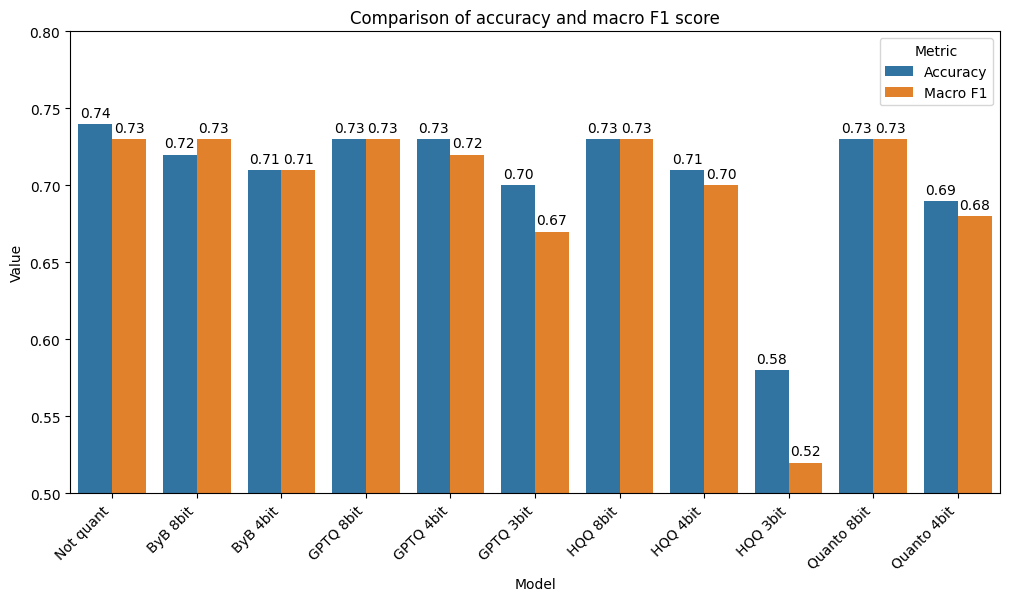

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit', 'Quanto 4bit'],
    'Accuracy': [0.74, 0.72, 0.71, 0.73, 0.73, 0.70, 0.73, 0.71, 0.58, 0.73, 0.69],
    'Macro F1': [0.73, 0.73, 0.71, 0.73, 0.72, 0.67, 0.73, 0.70, 0.52, 0.73, 0.68]
})

df_melt = df.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melt, x='Model', y='Value', hue='Metric')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of accuracy and macro F1 score')
plt.ylim(0.5, 0.8)
plt.xticks(rotation=45, ha='right')
plt.show()


We observe how the accuracy is higher with the base model and, between the quantized models, the 8-bit variants have a higher accuracy, although differences are minimal, not only between the quantized models, but also between them and the base model. 


### Memory use results

Measuring memeory needs is not an easy task. We decided to check the maximum memory need while inference (in GPU). Note that this measure tends to be higher due to needs associated with inference, specially when using batches.

We only measured this and not the disk memory required because of the way we store the models. Since we used LoRA to fine tune and train our base model with the classification layer, we don't store the whole model explicitly, but only the LoRA adpaters generated. Therefore, we are unable to compare additional memory usage metrics, such as disk memory requirements.

Now we show the maximum memory needed for inference for each model and inference configuration:

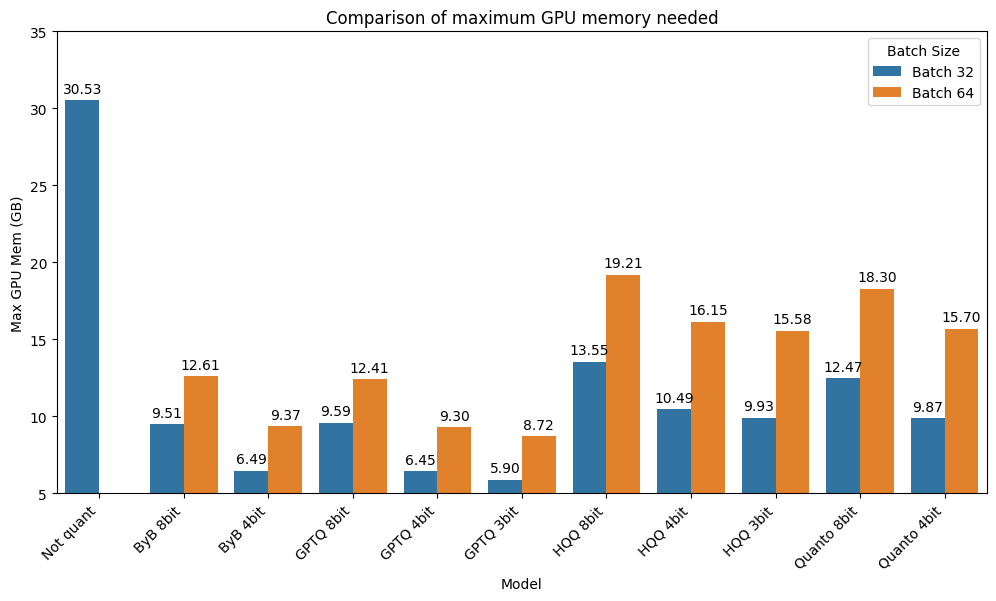

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit', 'Quanto 4bit'],
    'Batch 32': [30.53, 9.51, 6.49, 9.59, 6.45, 5.90, 13.55, 10.49, 9.93, 12.47, 9.87],
    'Batch 64': [0, 12.61, 9.37, 12.41, 9.30, 8.72, 19.21, 16.15, 15.58, 18.30, 15.70]
})

df_melt = df.melt(id_vars='Model', var_name='Batch Size', value_name='Max GPU Mem (GB)')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melt, x='Model', y='Max GPU Mem (GB)', hue='Batch Size')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of maximum GPU memory needed')
plt.ylim(5.0, 35.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how the maximum memory usage in GPU during inference increases with batch size for all models. The bigger the batch size, the higher the memory needs. In addition to this, we see how the base model needs considerable more memory compared to all quantized models, and between the quantized models, the 3bit variants require less memory than the 8bit and 4bit ones.

### Inference and quantization speed results

In this section we show the results obtained for inference time and quantization time:  

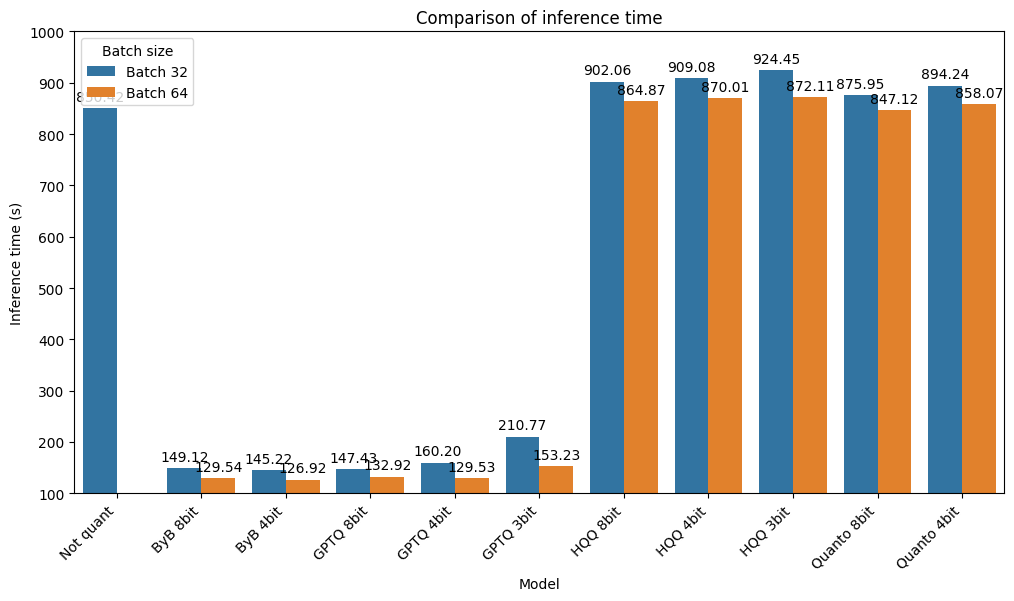

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit', 'Quanto 4bit'],
    'Batch 32': [850.42, 149.12, 145.22, 147.43, 160.20, 210.77, 902.06, 909.08, 924.45, 875.95, 894.24],
    'Batch 64': [0, 129.54, 126.92, 132.92, 129.53, 153.23, 864.87, 870.01, 872.11, 847.12, 858.07]
})

df_melt = df.melt(id_vars='Model', var_name='Batch size', value_name='Inference time (s)')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melt, x='Model', y='Inference time (s)', hue='Batch size')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of inference time')
plt.ylim(100.0, 1000.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how, with a big difference, BitsAndBytes and GPTQ models are the fastets ones. HQQ and Quanto models seem to perform even worse than the base model, although differences are small. Batch sizes also seem to affect, with larger batch sizes reducing inference time.

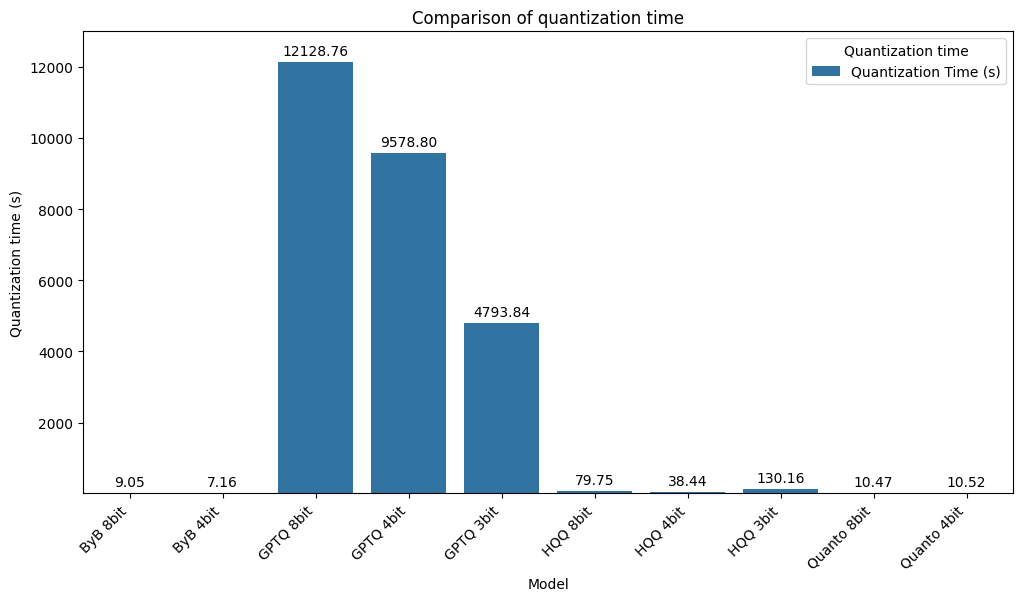

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit', 'Quanto 4bit'],
    'Quantization Time (s)': [9.052, 7.156, 12128.76, 9578.80, 4793.84, 79.749, 38.437, 130.165, 10.468, 10.519]
})

df_melt = df.melt(id_vars='Model', var_name='Quantization time', value_name='Quantization time (s)')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melt, x='Model', y='Quantization time (s)', hue='Quantization time')
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)
plt.title('Comparison of quantization time')
plt.ylim(5.0, 13000.0)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how GPTQ models need a lot of time to be quantized, with a huge difference with the other methods. Between the rest, BitsAndBytes is the fastest method to quantize. Regarding differences between bit count, it does not seem that there is a general relation between bit count and quantization time.

### Emissions results

The emissions are a little challenging to measure and compare. This is because we need to decide if we take into account the emissions generated during the quantization of the models. Our approach will show the resuts obtained for evaluation separated from the emissions for the quantization process, but will take them into consideration when comparing. We will measure the emissions of CO<sub>2</sub> in kilograms of CO<sub>2</sub>-equivalents \[CO<sub>2</sub>eq\]

The emissions generated by the evaluation process and the quantization were:


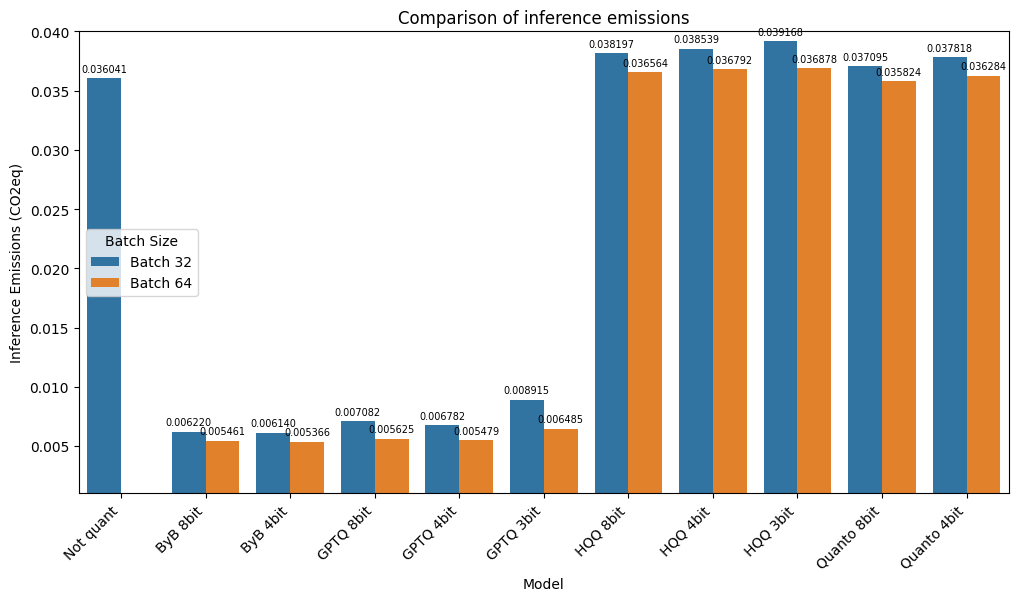

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['Not quant', 'ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit', 'Quanto 4bit'],
    'Batch 32': [0.036041, 0.006220, 0.006140, 0.007082, 0.006782, 0.008915, 0.038197, 0.038539, 0.039168, 0.037095, 0.037818],
    'Batch 64': [0,  0.005461, 0.005366, 0.005625, 0.005479, 0.006485, 0.036564, 0.036792, 0.036878, 0.035824, 0.036284]
})

df_melt = df.melt(id_vars='Model', var_name='Batch Size', value_name='Inference Emissions (CO2eq)')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melt, x='Model', y='Inference Emissions (CO2eq)', hue='Batch Size')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3, fontsize=7)
plt.title('Comparison of inference emissions')
plt.ylim(0.001, 0.04)
plt.xticks(rotation=45, ha='right')
plt.show()

We see how, following the same trend shown in speed results, BitsAndBytes and GPTQ models are the ones with the lower emissions, while HQQ and Quanto models have even higher emissions than the base model. The same way, higher batch sizes reduce emissions.

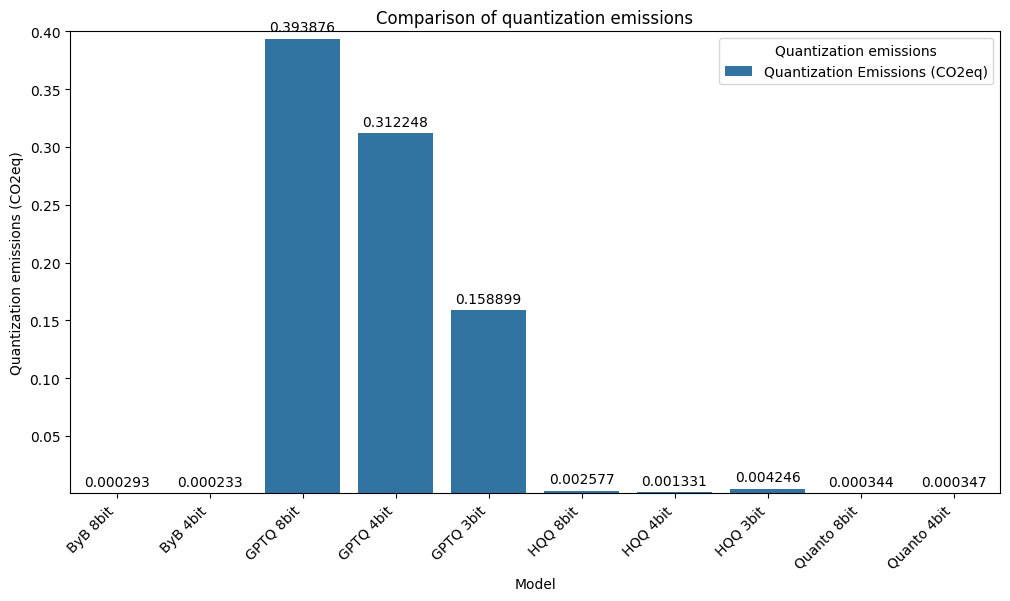

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Model': ['ByB 8bit', 'ByB 4bit', 'GPTQ 8bit', 'GPTQ 4bit', 'GPTQ 3bit', 'HQQ 8bit', 'HQQ 4bit', 'HQQ 3bit', 'Quanto 8bit', 'Quanto 4bit'],
    'Quantization Emissions (CO2eq)': [0.000293, 0.000233, 0.393876, 0.312248, 0.158899, 0.002577, 0.001331, 0.004246, 0.000344, 0.000347]
})

df_melt = df.melt(id_vars='Model', var_name='Quantization emissions', value_name='Quantization emissions (CO2eq)')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_melt, x='Model', y='Quantization emissions (CO2eq)', hue='Quantization emissions')
for container in ax.containers:
    ax.bar_label(container, fmt='%.6f', padding=3)
plt.title('Comparison of quantization emissions')
plt.ylim(0.0002, 0.4)
plt.xticks(rotation=45, ha='right')
plt.show()

Again, quantization emissions results follow the same trend seen before with quantization time results. GPTQ models have higher quantization emissions and between the rest BitsAndBytes has the lowest emissions. Regarding differences between bit count, it does not seem that there is a general relation between bit count and quantization emissions.




## Conclusions

Results show that:

1. Quantization does in fact reduce accuracy, and the lower the bit count, the higher this drop is. However, the drop with the methods used is not as significant, as we saw. Accuracy remains very close to the base model results, specially with 8bit models.
2. Quantized models are noticeably better in terms of memory usage compared to the base model.
3. Quantized models with **BitsAndBytes** and **GPTQ** are faster than the base model, but **HQQ** and **Quanto** models do not improbve the base model performance.
4. Emissions results are coherent with speed results, following the same trend.

